In [9]:
# Experiment 3 KD with a smaller model as student

In [1]:
# Split the training data into validation set and training set use a stratified k fold 
import numpy as np
import pandas as pd
import sklearn

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import RobustScaler, QuantileTransformer 

from sklearn.model_selection import StratifiedKFold, KFold

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Knowledge distillation 
# Modified from source: https://keras.io/examples/vision/knowledge_distillation/

import Distiller

In [4]:
# Load the saved dataset
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html
california_housing_data_train = pd.read_csv('Data/california_housing_train.txt')
california_housing_data_test = pd.read_csv('Data/california_housing_test.txt')

# This dataset have strong outliers due to the hard limit of the housing price
# remove those from the training set
california_housing_data_train = california_housing_data_train[california_housing_data_train['MedHouseVal'] < 5]  


In [5]:
# Set up the datasets
x_train = california_housing_data_train.iloc[:,0:7].to_numpy()
y_train = california_housing_data_train.iloc[:,-1].to_numpy()

x_test = california_housing_data_test.iloc[:,0:7].to_numpy()
y_test = california_housing_data_test.iloc[:,-1].to_numpy()

In [6]:
# Build the student model

def buildStudentModel():
    model = models.Sequential()    
    model.add(layers.Dense(8, activation='relu'))
        
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(1))    
    
    return model

In [7]:
# Construct/load models

teacher_model = tf.keras.models.load_model('MlpTeacherModel/MlpTeacherModel')

# Perform the 10 fold cross validation
number_of_folds = 10

skf = KFold(n_splits=number_of_folds)

In [8]:
# Haperparameter used in the experiment
number_of_epochs = 100

train_val_results_with_distillation = []
train_val_results_without_distillation = []

test_results_with_distillation = []
test_results_without_distillation = []

for i, (train_index, val_index) in enumerate(skf.split(x_train, y_train)):
    print(f"Fold {i}")
    
    studnet_model = buildStudentModel()
    studnet_model_without_distillation = keras.models.clone_model(studnet_model)
    
    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    
    x_val_fold = x_train[val_index]
    y_val_fold = y_train[val_index]
    
    distiller = Distiller.Distiller(student=studnet_model, teacher=teacher_model)
    distiller.compile(
        optimizer=keras.optimizers.Adam(),
        metrics=['mse', 'mae', 'mape'],
        student_loss_fn=tf.keras.losses.MeanAbsoluteError(),
        distillation_loss_fn=distiller.mse_distillation_loss_fucntion,
        alpha=0.1,
        temperature=10        
    )
    # Distill teacher to student
    history = distiller.fit(
        x_train_fold, 
        y_train_fold, 
        epochs=number_of_epochs,
        validation_data=(x_val_fold, y_val_fold)
    )
    train_val_results_with_distillation.append(history.history)
    
    # Train and evaluate the student model without distillation
    studnet_model_without_distillation.compile(
        optimizer=keras.optimizers.Adam(),
        loss=tf.keras.losses.MeanAbsoluteError(),
        metrics=['mse', 'mae', 'mape'],
    )

    # Train and evaluate student trained from scratch.
    history = studnet_model_without_distillation.fit(
        x_train_fold, 
        y_train_fold,
        epochs=number_of_epochs,
        validation_data=(x_val_fold, y_val_fold)
    )
    train_val_results_without_distillation.append(history.history)
    
print('Training done')

Fold 0
Epoch 1/100
443/443 [==============================] - 2s 2ms/step - mse: 26206.0703 - mae: 112.8931 - mape: 7424.1016 - student_loss: 112.8449 - distillation_loss: 26158.0338 - val_mse: 5326.9102 - val_mae: 56.5622 - val_mape: 3820.8577 - val_student_loss: 38.8268
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 612.8491 - mae: 8.7686 - mape: 605.6895 - student_loss: 8.7391 - distillation_loss: 610.8161 - val_mse: 5.1014 - val_mae: 1.7190 - val_mape: 129.4657 - val_student_loss: 2.1536
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 4.1923 - mae: 1.6001 - mape: 117.4696 - student_loss: 1.6013 - distillation_loss: 3.9320 - val_mse: 3.3956 - val_mae: 1.4061 - val_mape: 104.6914 - val_student_loss: 1.7902
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 2.8155 - mae: 1.3171 - mape: 95.3470 - student_loss: 1.3159 - distillation_loss: 2.4970 - val_mse: 2.3904 - val_mae: 1.1842 - val_mape: 86.6475 - val_stude

443/443 [==============================] - 1s 2ms/step - mse: 0.5594 - mae: 0.5687 - mape: 36.6923 - student_loss: 0.5704 - distillation_loss: 0.1467 - val_mse: 1.1544 - val_mae: 0.7991 - val_mape: 43.5878 - val_student_loss: 0.7713
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8823 - mae: 0.6487 - mape: 42.1235 - student_loss: 0.6574 - distillation_loss: 0.4913 - val_mse: 8.8529 - val_mae: 2.3774 - val_mape: 175.9909 - val_student_loss: 1.8695
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7747 - mae: 0.6312 - mape: 41.1956 - student_loss: 0.6305 - distillation_loss: 0.3554 - val_mse: 0.5400 - val_mae: 0.5823 - val_mape: 41.3392 - val_student_loss: 0.6838
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5980 - mae: 0.5750 - mape: 37.2090 - student_loss: 0.5748 - distillation_loss: 0.1750 - val_mse: 0.4908 - val_mae: 0.5382 - val_mape: 35.5258 - val_student_loss: 0.6063
Epoch 38/100
443/443 [======

443/443 [==============================] - 1s 2ms/step - mse: 0.5775 - mae: 0.5655 - mape: 36.2312 - student_loss: 0.5645 - distillation_loss: 0.1646 - val_mse: 0.5617 - val_mae: 0.5525 - val_mape: 31.5145 - val_student_loss: 0.6129
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5351 - mae: 0.5531 - mape: 35.4819 - student_loss: 0.5527 - distillation_loss: 0.1252 - val_mse: 0.5061 - val_mae: 0.5588 - val_mape: 38.3602 - val_student_loss: 0.6499
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6239 - mae: 0.5745 - mape: 36.8686 - student_loss: 0.5752 - distillation_loss: 0.2124 - val_mse: 0.4856 - val_mae: 0.5400 - val_mape: 36.2238 - val_student_loss: 0.6330
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5209 - mae: 0.5467 - mape: 35.0538 - student_loss: 0.5473 - distillation_loss: 0.1115 - val_mse: 0.5590 - val_mae: 0.6003 - val_mape: 43.0205 - val_student_loss: 0.7083
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.5175 - mae: 0.5436 - mape: 34.3074 - student_loss: 0.5428 - distillation_loss: 0.1097 - val_mse: 0.5475 - val_mae: 0.5489 - val_mape: 32.2499 - val_student_loss: 0.6508
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 32.6601 - mse: 5613.3257 - mae: 32.6601 - mape: 2193.5515 - val_loss: 0.7575 - val_mse: 0.9665 - val_mae: 0.7575 - val_mape: 48.2887
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7432 - mse: 0.9392 - mae: 0.7432 - mape: 49.3527 - val_loss: 0.7178 - val_mse: 0.8538 - val_mae: 0.7178 - val_mape: 54.6660
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6986 - mse: 0.8319 - mae: 0.6986 - mape: 45.9612 - val_loss: 0.6295 - val_mse: 0.6995 - val_mae: 0.6295 - val_mape: 40.9481
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6406 - mse: 0.7166 - mae: 0.6406 - mape: 41.5779 - val_loss: 0.5665 - val_mse: 0

443/443 [==============================] - 1s 2ms/step - loss: 0.5147 - mse: 0.4827 - mae: 0.5147 - mape: 31.3330 - val_loss: 0.5968 - val_mse: 0.5844 - val_mae: 0.5968 - val_mape: 42.9676
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5213 - mse: 0.4868 - mae: 0.5213 - mape: 31.9440 - val_loss: 0.4859 - val_mse: 0.4295 - val_mae: 0.4859 - val_mape: 30.4121
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5109 - mse: 0.4787 - mae: 0.5109 - mape: 31.2338 - val_loss: 0.5092 - val_mse: 0.4423 - val_mae: 0.5092 - val_mape: 34.6248
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5109 - mse: 0.4750 - mae: 0.5109 - mape: 31.2249 - val_loss: 0.4835 - val_mse: 0.4315 - val_mae: 0.4835 - val_mape: 29.1329
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5024 - mse: 0.4605 - mae: 0.5024 - mape: 30.5872 - val_loss: 0.5114 - val_mse: 0.4452 - val_mae: 0.5114 - val_mape: 34.1240
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4900 - mse: 0.4366 - mae: 0.4900 - mape: 30.0251 - val_loss: 0.4705 - val_mse: 0.4001 - val_mae: 0.4705 - val_mape: 28.6148
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4910 - mse: 0.4398 - mae: 0.4910 - mape: 29.9275 - val_loss: 0.4735 - val_mse: 0.4131 - val_mae: 0.4735 - val_mape: 28.1103
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4885 - mse: 0.4353 - mae: 0.4885 - mape: 29.7649 - val_loss: 0.4753 - val_mse: 0.4082 - val_mae: 0.4753 - val_mape: 28.6698
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4878 - mse: 0.4339 - mae: 0.4878 - mape: 29.6655 - val_loss: 0.4933 - val_mse: 0.4179 - val_mae: 0.4933 - val_mape: 32.2720
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4867 - mse: 0.4410 - mae: 0.4867 - mape: 29.5472 - val_loss: 0.5073 - val_mse: 0.4736 - val_mae: 0.5073 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5849 - mae: 0.5764 - mape: 37.0712 - student_loss: 0.5762 - distillation_loss: 0.1729 - val_mse: 0.4983 - val_mae: 0.5465 - val_mape: 36.1949 - val_student_loss: 0.4243
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5266 - mae: 0.5511 - mape: 35.4181 - student_loss: 0.5517 - distillation_loss: 0.1138 - val_mse: 0.4823 - val_mae: 0.5328 - val_mape: 34.2858 - val_student_loss: 0.4555
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0814 - mae: 0.6893 - mape: 44.7619 - student_loss: 0.6873 - distillation_loss: 0.6674 - val_mse: 0.5178 - val_mae: 0.5367 - val_mape: 31.4849 - val_student_loss: 0.4041
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5862 - mae: 0.5714 - mape: 36.8187 - student_loss: 0.5708 - distillation_loss: 0.1723 - val_mse: 0.4934 - val_mae: 0.5269 - val_mape: 31.8328 - val_student_loss: 0.4016
Epoch 22/100
443

443/443 [==============================] - 1s 2ms/step - mse: 0.5573 - mae: 0.5648 - mape: 36.2413 - student_loss: 0.5648 - distillation_loss: 0.1488 - val_mse: 0.5736 - val_mae: 0.5890 - val_mape: 40.8524 - val_student_loss: 0.4795
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5034 - mae: 0.5377 - mape: 34.5281 - student_loss: 0.5391 - distillation_loss: 0.1003 - val_mse: 0.4716 - val_mae: 0.5217 - val_mape: 32.7471 - val_student_loss: 0.3713
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 1.4229 - mae: 0.7220 - mape: 46.9822 - student_loss: 0.7223 - distillation_loss: 1.0251 - val_mse: 0.5697 - val_mae: 0.5914 - val_mape: 41.1689 - val_student_loss: 0.4867
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4926 - mae: 0.5323 - mape: 34.3168 - student_loss: 0.5322 - distillation_loss: 0.0867 - val_mse: 0.4771 - val_mae: 0.5196 - val_mape: 31.7430 - val_student_loss: 0.3822
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.5311 - mae: 0.5487 - mape: 35.3258 - student_loss: 0.5477 - distillation_loss: 0.1302 - val_mse: 0.4856 - val_mae: 0.5386 - val_mape: 35.6424 - val_student_loss: 0.3975
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5300 - mae: 0.5516 - mape: 35.3740 - student_loss: 0.5544 - distillation_loss: 0.1287 - val_mse: 0.4817 - val_mae: 0.5148 - val_mape: 30.2465 - val_student_loss: 0.3175
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5529 - mae: 0.5602 - mape: 35.7838 - student_loss: 0.5596 - distillation_loss: 0.1498 - val_mse: 0.5105 - val_mae: 0.5532 - val_mape: 37.1308 - val_student_loss: 0.4185
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5343 - mae: 0.5516 - mape: 35.2860 - student_loss: 0.5506 - distillation_loss: 0.1284 - val_mse: 0.7129 - val_mae: 0.6177 - val_mape: 32.4963 - val_student_loss: 0.3111
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6265 - mse: 0.7170 - mae: 0.6265 - mape: 38.8828 - val_loss: 1.4373 - val_mse: 3.6059 - val_mae: 1.4373 - val_mape: 80.2990
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6206 - mse: 0.7161 - mae: 0.6206 - mape: 38.2872 - val_loss: 0.5571 - val_mse: 0.5366 - val_mae: 0.5571 - val_mape: 35.7462
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6275 - mse: 0.7033 - mae: 0.6275 - mape: 39.0499 - val_loss: 0.5721 - val_mse: 0.5690 - val_mae: 0.5721 - val_mape: 37.3790
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6083 - mse: 0.6571 - mae: 0.6083 - mape: 37.4411 - val_loss: 0.5558 - val_mse: 0.5614 - val_mae: 0.5558 - val_mape: 31.6128
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6873 - mse: 0.8697 - mae: 0.6873 - mape: 43.1722 - val_loss: 0.6484 - val_mse: 0.7745 - val_mae: 0.6484 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.6077 - mse: 0.7082 - mae: 0.6077 - mape: 37.6081 - val_loss: 0.5615 - val_mse: 0.6128 - val_mae: 0.5615 - val_mape: 29.7180
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6146 - mse: 0.7418 - mae: 0.6146 - mape: 38.2948 - val_loss: 0.5083 - val_mse: 0.4857 - val_mae: 0.5083 - val_mape: 30.1515
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6187 - mse: 0.7178 - mae: 0.6187 - mape: 38.5104 - val_loss: 0.6095 - val_mse: 0.7110 - val_mae: 0.6095 - val_mape: 32.8533
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5719 - mse: 0.6023 - mae: 0.5719 - mape: 35.1550 - val_loss: 0.5402 - val_mse: 0.5263 - val_mae: 0.5402 - val_mape: 35.2339
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5951 - mse: 0.7124 - mae: 0.5951 - mape: 36.9874 - val_loss: 0.5872 - val_mse: 0.6709 - val_mae: 0.5872 - val_mape: 31.2427
Epo

443/443 [==============================] - 1s 3ms/step - mse: 42.4618 - mae: 2.4378 - mape: 152.8301 - student_loss: 2.4342 - distillation_loss: 41.8261 - val_mse: 2.1949 - val_mae: 1.1691 - val_mape: 76.7646 - val_student_loss: 1.2809
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 2.1725 - mae: 1.1475 - mape: 74.0269 - student_loss: 1.1471 - distillation_loss: 1.7499 - val_mse: 1.9238 - val_mae: 1.0909 - val_mape: 65.8236 - val_student_loss: 1.2491
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 1.7271 - mae: 1.0285 - mape: 67.0075 - student_loss: 1.0274 - distillation_loss: 1.2952 - val_mse: 1.3888 - val_mae: 0.9357 - val_mape: 64.3709 - val_student_loss: 0.9166
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 1.4038 - mae: 0.9248 - mape: 61.1941 - student_loss: 0.9248 - distillation_loss: 0.9733 - val_mse: 1.1585 - val_mae: 0.8446 - val_mape: 55.3363 - val_student_loss: 0.8393
Epoch 5/100
443/443 [========

443/443 [==============================] - 1s 3ms/step - mse: 0.8891 - mae: 0.6402 - mape: 41.4284 - student_loss: 0.6409 - distillation_loss: 0.4617 - val_mse: 0.5155 - val_mae: 0.5498 - val_mape: 37.0049 - val_student_loss: 0.4875
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5461 - mae: 0.5647 - mape: 37.0654 - student_loss: 0.5642 - distillation_loss: 0.1261 - val_mse: 0.5126 - val_mae: 0.5519 - val_mape: 37.3472 - val_student_loss: 0.4894
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5204 - mae: 0.5511 - mape: 36.0852 - student_loss: 0.5538 - distillation_loss: 0.0994 - val_mse: 0.5083 - val_mae: 0.5470 - val_mape: 36.8750 - val_student_loss: 0.5207
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5454 - mae: 0.5613 - mape: 36.4935 - student_loss: 0.5616 - distillation_loss: 0.1274 - val_mse: 0.5722 - val_mae: 0.5523 - val_mape: 31.9605 - val_student_loss: 0.5039
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4695 - mae: 0.5168 - mape: 33.1792 - student_loss: 0.5162 - distillation_loss: 0.0654 - val_mse: 0.4600 - val_mae: 0.5003 - val_mape: 30.9414 - val_student_loss: 0.4556
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4731 - mae: 0.5189 - mape: 33.1441 - student_loss: 0.5191 - distillation_loss: 0.0707 - val_mse: 0.4612 - val_mae: 0.5027 - val_mape: 31.4048 - val_student_loss: 0.4356
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4631 - mae: 0.5131 - mape: 32.9317 - student_loss: 0.5127 - distillation_loss: 0.0597 - val_mse: 0.4658 - val_mae: 0.4978 - val_mape: 30.2043 - val_student_loss: 0.4242
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4608 - mae: 0.5112 - mape: 32.8171 - student_loss: 0.5107 - distillation_loss: 0.0613 - val_mse: 0.4763 - val_mae: 0.5383 - val_mape: 36.7099 - val_student_loss: 0.4718
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4065 - mae: 0.4802 - mape: 31.0899 - student_loss: 0.4792 - distillation_loss: 0.0240 - val_mse: 0.4024 - val_mae: 0.4760 - val_mape: 30.8008 - val_student_loss: 0.4477
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 7.6033 - mse: 839.6713 - mae: 7.6033 - mape: 514.5451 - val_loss: 1.1763 - val_mse: 2.2122 - val_mae: 1.1763 - val_mape: 95.3204
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8751 - mse: 2.6952 - mae: 0.8751 - mape: 58.4250 - val_loss: 1.1360 - val_mse: 2.2109 - val_mae: 1.1360 - val_mape: 59.5374
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7834 - mse: 1.6112 - mae: 0.7834 - mape: 51.5667 - val_loss: 0.8974 - val_mse: 1.4566 - val_mae: 0.8974 - val_mape: 49.1723
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7673 - mse: 1.1969 - mae: 0.7673 - mape: 50.2281 - val_loss: 0.9047 - val_mse: 1.313

443/443 [==============================] - 1s 2ms/step - loss: 0.6193 - mse: 0.6986 - mae: 0.6193 - mape: 38.5644 - val_loss: 0.5018 - val_mse: 0.4875 - val_mae: 0.5018 - val_mape: 30.3204
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6693 - mse: 0.8721 - mae: 0.6693 - mape: 42.3624 - val_loss: 0.6920 - val_mse: 0.7687 - val_mae: 0.6920 - val_mape: 50.2607
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6248 - mse: 0.7604 - mae: 0.6248 - mape: 38.9857 - val_loss: 0.6732 - val_mse: 0.7153 - val_mae: 0.6732 - val_mape: 48.7777
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6376 - mse: 0.7541 - mae: 0.6376 - mape: 40.2917 - val_loss: 1.6083 - val_mse: 4.1881 - val_mae: 1.6083 - val_mape: 96.2071
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6943 - mse: 1.0095 - mae: 0.6943 - mape: 43.7627 - val_loss: 0.5376 - val_mse: 0.5069 - val_mae: 0.5376 - val_mape: 35.4016
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6184 - mse: 0.7208 - mae: 0.6184 - mape: 38.7018 - val_loss: 0.5276 - val_mse: 0.4656 - val_mae: 0.5276 - val_mape: 35.2931
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5970 - mse: 0.6733 - mae: 0.5970 - mape: 36.9677 - val_loss: 0.4897 - val_mse: 0.4402 - val_mae: 0.4897 - val_mape: 30.5189
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6308 - mse: 0.7170 - mae: 0.6308 - mape: 39.5196 - val_loss: 0.4959 - val_mse: 0.4728 - val_mae: 0.4959 - val_mape: 28.9240
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6241 - mse: 0.7621 - mae: 0.6241 - mape: 39.0262 - val_loss: 0.5112 - val_mse: 0.4860 - val_mae: 0.5112 - val_mape: 30.6500
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6012 - mse: 0.6503 - mae: 0.6012 - mape: 37.5253 - val_loss: 0.6848 - val_mse: 0.8482 - val_mae: 0.6848 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 3ms/step - mse: 2.8347 - mae: 0.9495 - mape: 62.2586 - student_loss: 0.9485 - distillation_loss: 2.4010 - val_mse: 0.7868 - val_mae: 0.6287 - val_mape: 36.0408 - val_student_loss: 0.1601
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 1.7096 - mae: 0.8275 - mape: 54.1142 - student_loss: 0.8260 - distillation_loss: 1.2893 - val_mse: 0.7755 - val_mae: 0.7080 - val_mape: 53.2364 - val_student_loss: 0.6114
Epoch 20/100
443/443 [==============================] - 1s 3ms/step - mse: 6.2567 - mae: 1.1833 - mape: 77.9179 - student_loss: 1.1799 - distillation_loss: 5.7894 - val_mse: 0.6173 - val_mae: 0.5581 - val_mape: 33.6896 - val_student_loss: 0.2432
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9284 - mae: 0.6850 - mape: 43.8809 - student_loss: 0.6847 - distillation_loss: 0.5155 - val_mse: 0.5556 - val_mae: 0.5691 - val_mape: 38.8126 - val_student_loss: 0.3887
Epoch 22/100
443

443/443 [==============================] - 1s 2ms/step - mse: 0.9978 - mae: 0.6690 - mape: 43.3934 - student_loss: 0.6708 - distillation_loss: 0.5785 - val_mse: 0.6046 - val_mae: 0.6141 - val_mape: 44.2418 - val_student_loss: 0.4957
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5793 - mae: 0.5645 - mape: 36.3008 - student_loss: 0.5656 - distillation_loss: 0.1672 - val_mse: 0.9563 - val_mae: 0.7842 - val_mape: 59.1872 - val_student_loss: 0.7964
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0053 - mae: 0.7013 - mape: 45.0631 - student_loss: 0.7006 - distillation_loss: 0.5987 - val_mse: 1.0396 - val_mae: 0.8111 - val_mape: 61.6473 - val_student_loss: 0.6574
Epoch 54/100
443/443 [==============================] - 1s 3ms/step - mse: 2.3093 - mae: 0.9333 - mape: 60.4146 - student_loss: 0.9324 - distillation_loss: 1.9053 - val_mse: 0.7010 - val_mae: 0.6622 - val_mape: 49.2522 - val_student_loss: 0.5686
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 3ms/step - mse: 1.0134 - mae: 0.6641 - mape: 42.7643 - student_loss: 0.6630 - distillation_loss: 0.5826 - val_mse: 0.5080 - val_mae: 0.5319 - val_mape: 34.3844 - val_student_loss: 0.3924
Epoch 85/100
443/443 [==============================] - 1s 3ms/step - mse: 4.5415 - mae: 1.0878 - mape: 70.4332 - student_loss: 1.0847 - distillation_loss: 4.1124 - val_mse: 0.7914 - val_mae: 0.7116 - val_mape: 54.0408 - val_student_loss: 0.6551
Epoch 86/100
443/443 [==============================] - 1s 3ms/step - mse: 0.5991 - mae: 0.5829 - mape: 37.2716 - student_loss: 0.5825 - distillation_loss: 0.1928 - val_mse: 0.9306 - val_mae: 0.7735 - val_mape: 59.6968 - val_student_loss: 0.7195
Epoch 87/100
443/443 [==============================] - 1s 3ms/step - mse: 3.1482 - mae: 0.8699 - mape: 55.9787 - student_loss: 0.8691 - distillation_loss: 2.7336 - val_mse: 0.5049 - val_mae: 0.5392 - val_mape: 35.9380 - val_student_loss: 0.3699
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5907 - mse: 0.6342 - mae: 0.5907 - mape: 36.0308 - val_loss: 0.8710 - val_mse: 1.2375 - val_mae: 0.8710 - val_mape: 65.9296
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6771 - mse: 0.8598 - mae: 0.6771 - mape: 42.0841 - val_loss: 0.7116 - val_mse: 0.8351 - val_mae: 0.7116 - val_mape: 52.4421
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6130 - mse: 0.6974 - mae: 0.6130 - mape: 37.5483 - val_loss: 0.8729 - val_mse: 1.2435 - val_mae: 0.8729 - val_mape: 66.2030
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6158 - mse: 0.7163 - mae: 0.6158 - mape: 37.8508 - val_loss: 0.5386 - val_mse: 0.5871 - val_mae: 0.5386 - val_mape: 32.2798
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6533 - mse: 0.7984 - mae: 0.6533 - mape: 40.2336 - val_loss: 0.6620 - val_mse: 0.7133 - val_mae: 0.6620 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.5408 - mse: 0.5572 - mae: 0.5408 - mape: 33.5475 - val_loss: 0.5971 - val_mse: 0.5932 - val_mae: 0.5971 - val_mape: 42.6177
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5481 - mse: 0.5617 - mae: 0.5481 - mape: 33.6870 - val_loss: 0.5264 - val_mse: 0.5202 - val_mae: 0.5264 - val_mape: 35.5349
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5394 - mse: 0.5752 - mae: 0.5394 - mape: 33.2051 - val_loss: 0.5294 - val_mse: 0.4949 - val_mae: 0.5294 - val_mape: 35.9013
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5422 - mse: 0.5588 - mae: 0.5422 - mape: 33.4239 - val_loss: 0.5517 - val_mse: 0.5552 - val_mae: 0.5517 - val_mape: 37.4684
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5370 - mse: 0.5362 - mae: 0.5370 - mape: 32.9324 - val_loss: 0.5274 - val_mse: 0.5624 - val_mae: 0.5274 - val_mape: 35.4157
Epo

443/443 [==============================] - 1s 3ms/step - mse: 628.7902 - mae: 7.7503 - mape: 531.2482 - student_loss: 7.7247 - distillation_loss: 625.1588 - val_mse: 2.7773 - val_mae: 1.3467 - val_mape: 94.1643 - val_student_loss: 0.8125
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 3.3178 - mae: 1.3700 - mape: 97.8875 - student_loss: 1.3697 - distillation_loss: 2.8432 - val_mse: 2.4540 - val_mae: 1.2661 - val_mape: 89.1716 - val_student_loss: 0.7580
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 2.5947 - mae: 1.2682 - mape: 90.7526 - student_loss: 1.2673 - distillation_loss: 2.1257 - val_mse: 2.1017 - val_mae: 1.1681 - val_mape: 83.1905 - val_student_loss: 0.7275
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 2.1377 - mae: 1.1570 - mape: 83.2117 - student_loss: 1.1575 - distillation_loss: 1.6875 - val_mse: 1.7672 - val_mae: 1.0694 - val_mape: 75.5155 - val_student_loss: 0.6716
Epoch 5/100
443/443 [======

443/443 [==============================] - 1s 3ms/step - mse: 0.5578 - mae: 0.5644 - mape: 36.9736 - student_loss: 0.5650 - distillation_loss: 0.1434 - val_mse: 0.4898 - val_mae: 0.5427 - val_mape: 36.7702 - val_student_loss: 0.5003
Epoch 35/100
443/443 [==============================] - 1s 3ms/step - mse: 0.5785 - mae: 0.5627 - mape: 36.8792 - student_loss: 0.5638 - distillation_loss: 0.1575 - val_mse: 0.4821 - val_mae: 0.5323 - val_mape: 35.1941 - val_student_loss: 0.5351
Epoch 36/100
443/443 [==============================] - 1s 3ms/step - mse: 0.5639 - mae: 0.5633 - mape: 36.7230 - student_loss: 0.5633 - distillation_loss: 0.1511 - val_mse: 0.4771 - val_mae: 0.5174 - val_mape: 32.0502 - val_student_loss: 0.5564
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6126 - mae: 0.5766 - mape: 37.7571 - student_loss: 0.5768 - distillation_loss: 0.2001 - val_mse: 0.8738 - val_mae: 0.7672 - val_mape: 57.2745 - val_student_loss: 0.5397
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.5171 - mae: 0.5373 - mape: 35.1554 - student_loss: 0.5376 - distillation_loss: 0.1140 - val_mse: 0.4543 - val_mae: 0.5168 - val_mape: 34.3018 - val_student_loss: 0.5175
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4722 - mae: 0.5216 - mape: 34.0254 - student_loss: 0.5212 - distillation_loss: 0.0704 - val_mse: 0.4571 - val_mae: 0.5055 - val_mape: 31.2513 - val_student_loss: 0.5595
Epoch 69/100
443/443 [==============================] - 1s 3ms/step - mse: 0.5127 - mae: 0.5404 - mape: 35.1506 - student_loss: 0.5400 - distillation_loss: 0.1092 - val_mse: 0.4613 - val_mae: 0.5050 - val_mape: 30.5579 - val_student_loss: 0.5632
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5030 - mae: 0.5318 - mape: 34.4924 - student_loss: 0.5323 - distillation_loss: 0.1001 - val_mse: 0.5054 - val_mae: 0.5630 - val_mape: 39.0915 - val_student_loss: 0.4874
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4533 - mae: 0.5099 - mape: 32.9502 - student_loss: 0.5097 - distillation_loss: 0.0500 - val_mse: 0.4562 - val_mae: 0.5180 - val_mape: 34.1240 - val_student_loss: 0.5090
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 37.0476 - mse: 20084.2422 - mae: 37.0476 - mape: 2538.4082 - val_loss: 1.1651 - val_mse: 2.0277 - val_mae: 1.1651 - val_mape: 89.7986
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.4428 - mse: 11.7099 - mae: 1.4428 - mape: 99.3510 - val_loss: 1.7405 - val_mse: 5.0501 - val_mae: 1.7405 - val_mape: 139.1450
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 1.4563 - mse: 5.8270 - mae: 1.4563 - mape: 97.9707 - val_loss: 1.1650 - val_mse: 2.1536 - val_mae: 1.1650 - val_mape: 92.8994
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0131 - mse: 1.9376 - mae: 1.0131 - mape: 67.6823 - val_loss: 1.4718 - val_mse

443/443 [==============================] - 1s 2ms/step - loss: 0.8192 - mse: 1.3044 - mae: 0.8192 - mape: 52.1833 - val_loss: 0.5495 - val_mse: 0.5750 - val_mae: 0.5495 - val_mape: 29.6588
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8152 - mse: 1.3558 - mae: 0.8152 - mape: 52.0833 - val_loss: 1.1028 - val_mse: 2.0092 - val_mae: 1.1028 - val_mape: 61.2853
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9089 - mse: 1.7314 - mae: 0.9089 - mape: 58.1733 - val_loss: 0.7016 - val_mse: 0.7718 - val_mae: 0.7016 - val_mape: 50.2492
Epoch 43/100
443/443 [==============================] - 1s 1ms/step - loss: 0.8438 - mse: 1.5793 - mae: 0.8438 - mape: 53.9485 - val_loss: 0.5695 - val_mse: 0.5930 - val_mae: 0.5695 - val_mape: 31.4946
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8387 - mse: 1.4476 - mae: 0.8387 - mape: 53.8299 - val_loss: 0.7812 - val_mse: 1.0444 - val_mae: 0.7812 - val_mape: 40.9219
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7724 - mse: 1.2471 - mae: 0.7724 - mape: 48.8616 - val_loss: 1.7358 - val_mse: 4.7404 - val_mae: 1.7358 - val_mape: 102.1336
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7818 - mse: 1.3202 - mae: 0.7818 - mape: 49.7101 - val_loss: 0.5769 - val_mse: 0.5382 - val_mae: 0.5769 - val_mape: 39.2522
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7612 - mse: 1.1081 - mae: 0.7612 - mape: 48.4784 - val_loss: 1.3697 - val_mse: 3.0130 - val_mae: 1.3697 - val_mape: 100.9149
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8493 - mse: 1.6461 - mae: 0.8493 - mape: 54.3533 - val_loss: 0.5204 - val_mse: 0.4951 - val_mae: 0.5204 - val_mape: 30.1099
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8083 - mse: 1.3575 - mae: 0.8083 - mape: 51.6273 - val_loss: 0.7603 - val_mse: 0.9820 - val_mae: 0.7603 - val_ma

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 2.0856 - mae: 0.8338 - mape: 54.3541 - student_loss: 0.8344 - distillation_loss: 1.6564 - val_mse: 1.1613 - val_mae: 0.8323 - val_mape: 61.5802 - val_student_loss: 1.0287
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0764 - mae: 0.7057 - mape: 45.7868 - student_loss: 0.7037 - distillation_loss: 0.6467 - val_mse: 0.5722 - val_mae: 0.5419 - val_mape: 31.8168 - val_student_loss: 0.7953
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8473 - mae: 0.6530 - mape: 42.2325 - student_loss: 0.6520 - distillation_loss: 0.4266 - val_mse: 0.6359 - val_mae: 0.5391 - val_mape: 32.4342 - val_student_loss: 0.7858
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5463 - mae: 0.5612 - mape: 36.2427 - student_loss: 0.5611 - distillation_loss: 0.1352 - val_mse: 0.5111 - val_mae: 0.5422 - val_mape: 35.6563 - val_student_loss: 0.7702
Epoch 22/100
443

443/443 [==============================] - 1s 2ms/step - mse: 0.5776 - mae: 0.5700 - mape: 36.9365 - student_loss: 0.5696 - distillation_loss: 0.1615 - val_mse: 0.5243 - val_mae: 0.5241 - val_mape: 31.4937 - val_student_loss: 0.7511
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9202 - mae: 0.6532 - mape: 42.5971 - student_loss: 0.6521 - distillation_loss: 0.5054 - val_mse: 0.6799 - val_mae: 0.6045 - val_mape: 33.1012 - val_student_loss: 0.9257
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6805 - mae: 0.5959 - mape: 38.4046 - student_loss: 0.5961 - distillation_loss: 0.2761 - val_mse: 0.5430 - val_mae: 0.5605 - val_mape: 38.5590 - val_student_loss: 0.7338
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8049 - mae: 0.6286 - mape: 40.6243 - student_loss: 0.6275 - distillation_loss: 0.3904 - val_mse: 0.4915 - val_mae: 0.5214 - val_mape: 34.1194 - val_student_loss: 0.6786
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.5730 - mae: 0.5745 - mape: 37.1791 - student_loss: 0.5748 - distillation_loss: 0.1603 - val_mse: 0.5007 - val_mae: 0.5167 - val_mape: 32.6643 - val_student_loss: 0.6953
Epoch 85/100
443/443 [==============================] - 1s 3ms/step - mse: 0.5112 - mae: 0.5439 - mape: 35.1468 - student_loss: 0.5449 - distillation_loss: 0.0964 - val_mse: 0.4898 - val_mae: 0.5221 - val_mape: 33.6888 - val_student_loss: 0.6829
Epoch 86/100
443/443 [==============================] - 1s 3ms/step - mse: 1.2336 - mae: 0.6685 - mape: 43.3226 - student_loss: 0.6676 - distillation_loss: 0.8176 - val_mse: 0.5392 - val_mae: 0.5474 - val_mape: 37.0740 - val_student_loss: 0.7085
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5871 - mae: 0.5788 - mape: 37.6327 - student_loss: 0.5796 - distillation_loss: 0.1761 - val_mse: 0.5925 - val_mae: 0.5431 - val_mape: 36.0304 - val_student_loss: 0.7092
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7692 - mse: 0.9818 - mae: 0.7692 - mape: 50.5034 - val_loss: 0.7679 - val_mse: 1.0029 - val_mae: 0.7679 - val_mape: 50.2065
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7697 - mse: 0.9830 - mae: 0.7697 - mape: 50.4515 - val_loss: 0.7683 - val_mse: 1.0021 - val_mae: 0.7683 - val_mape: 50.3567
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7689 - mse: 0.9850 - mae: 0.7689 - mape: 50.2082 - val_loss: 0.7669 - val_mse: 0.9957 - val_mae: 0.7669 - val_mape: 50.3909
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7687 - mse: 0.9794 - mae: 0.7687 - mape: 50.5482 - val_loss: 0.7675 - val_mse: 0.9995 - val_mae: 0.7675 - val_mape: 50.3728
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7694 - mse: 0.9837 - mae: 0.7694 - mape: 50.3368 - val_loss: 0.7673 - val_mse: 0.9985 - val_mae: 0.7673 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.5582 - mse: 0.8257 - mae: 0.5582 - mape: 33.2279 - val_loss: 0.5540 - val_mse: 0.9588 - val_mae: 0.5540 - val_mape: 30.7277
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5654 - mse: 0.8475 - mae: 0.5654 - mape: 33.9833 - val_loss: 0.5448 - val_mse: 0.8596 - val_mae: 0.5448 - val_mape: 33.0232
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5686 - mse: 0.8070 - mae: 0.5686 - mape: 34.0966 - val_loss: 0.5519 - val_mse: 0.9307 - val_mae: 0.5519 - val_mape: 31.0009
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5598 - mse: 0.7943 - mae: 0.5598 - mape: 33.3838 - val_loss: 0.5406 - val_mse: 0.9502 - val_mae: 0.5406 - val_mape: 30.5206
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5638 - mse: 0.8765 - mae: 0.5638 - mape: 33.8374 - val_loss: 0.5421 - val_mse: 0.9102 - val_mae: 0.5421 - val_mape: 31.9135
Epo

443/443 [==============================] - 1s 2ms/step - mse: 218.7861 - mae: 5.6066 - mape: 403.0090 - student_loss: 5.5921 - distillation_loss: 217.2432 - val_mse: 2.5454 - val_mae: 1.2366 - val_mape: 94.4260 - val_student_loss: 0.9462
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 6.0654 - mae: 1.1105 - mape: 86.7872 - student_loss: 1.1093 - distillation_loss: 5.5409 - val_mse: 1.4248 - val_mae: 0.9161 - val_mape: 63.0986 - val_student_loss: 1.3279
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 4.9470 - mae: 1.0212 - mape: 74.8712 - student_loss: 1.0231 - distillation_loss: 4.4092 - val_mse: 1.2641 - val_mae: 0.8685 - val_mape: 57.5532 - val_student_loss: 1.2548
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 4.0464 - mae: 0.9684 - mape: 68.2542 - student_loss: 0.9675 - distillation_loss: 3.5064 - val_mse: 1.1272 - val_mae: 0.8302 - val_mape: 56.4088 - val_student_loss: 1.2430
Epoch 5/100
443/443 [======

443/443 [==============================] - 1s 2ms/step - mse: 0.5359 - mae: 0.5583 - mape: 36.6994 - student_loss: 0.5598 - distillation_loss: 0.1185 - val_mse: 0.5424 - val_mae: 0.5427 - val_mape: 32.8390 - val_student_loss: 1.1346
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5591 - mae: 0.5673 - mape: 37.3417 - student_loss: 0.5664 - distillation_loss: 0.1422 - val_mse: 0.6855 - val_mae: 0.6516 - val_mape: 45.0281 - val_student_loss: 0.6223
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5387 - mae: 0.5598 - mape: 36.6490 - student_loss: 0.5596 - distillation_loss: 0.1181 - val_mse: 0.5253 - val_mae: 0.5439 - val_mape: 34.2389 - val_student_loss: 1.0067
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5514 - mae: 0.5620 - mape: 36.6732 - student_loss: 0.5640 - distillation_loss: 0.1354 - val_mse: 1.2783 - val_mae: 0.9307 - val_mape: 68.4419 - val_student_loss: 0.4588
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 3ms/step - mse: 0.5101 - mae: 0.5439 - mape: 35.4049 - student_loss: 0.5424 - distillation_loss: 0.0957 - val_mse: 0.5070 - val_mae: 0.5354 - val_mape: 33.6340 - val_student_loss: 0.9341
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4890 - mae: 0.5314 - mape: 34.5043 - student_loss: 0.5304 - distillation_loss: 0.0778 - val_mse: 0.5095 - val_mae: 0.5324 - val_mape: 32.8252 - val_student_loss: 0.9643
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5031 - mae: 0.5402 - mape: 35.0556 - student_loss: 0.5402 - distillation_loss: 0.0939 - val_mse: 0.6218 - val_mae: 0.5722 - val_mape: 32.1128 - val_student_loss: 1.1452
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5048 - mae: 0.5426 - mape: 35.6922 - student_loss: 0.5430 - distillation_loss: 0.0902 - val_mse: 0.5360 - val_mae: 0.5321 - val_mape: 30.6710 - val_student_loss: 1.1286
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4652 - mae: 0.5170 - mape: 33.2688 - student_loss: 0.5171 - distillation_loss: 0.0634 - val_mse: 0.4824 - val_mae: 0.5181 - val_mape: 31.9312 - val_student_loss: 0.9626
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 4.5286 - mse: 553.4800 - mae: 4.5286 - mape: 301.3315 - val_loss: 1.0936 - val_mse: 2.0521 - val_mae: 1.0936 - val_mape: 56.3834
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9781 - mse: 3.7593 - mae: 0.9781 - mape: 65.0225 - val_loss: 0.7428 - val_mse: 0.9995 - val_mae: 0.7428 - val_mape: 38.8725
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9617 - mse: 3.4348 - mae: 0.9617 - mape: 63.5227 - val_loss: 1.2927 - val_mse: 2.8372 - val_mae: 1.2927 - val_mape: 66.8882
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9198 - mse: 3.1404 - mae: 0.9198 - mape: 60.8685 - val_loss: 1.0332 - val_mse: 1.735

443/443 [==============================] - 1s 2ms/step - loss: 0.7064 - mse: 0.9734 - mae: 0.7064 - mape: 44.3123 - val_loss: 0.6566 - val_mse: 0.8218 - val_mae: 0.6566 - val_mape: 34.1030
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6879 - mse: 0.9026 - mae: 0.6879 - mape: 43.5023 - val_loss: 0.5501 - val_mse: 0.6152 - val_mae: 0.5501 - val_mape: 29.4209
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7360 - mse: 1.0585 - mae: 0.7360 - mape: 46.6924 - val_loss: 0.5393 - val_mse: 0.5785 - val_mae: 0.5393 - val_mape: 29.1649
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7247 - mse: 1.0051 - mae: 0.7247 - mape: 45.8114 - val_loss: 0.5714 - val_mse: 0.6534 - val_mae: 0.5714 - val_mape: 30.8439
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6575 - mse: 0.8225 - mae: 0.6575 - mape: 40.8246 - val_loss: 1.2208 - val_mse: 2.6099 - val_mae: 1.2208 - val_mape: 67.8824
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6410 - mse: 0.8138 - mae: 0.6410 - mape: 40.0474 - val_loss: 0.6656 - val_mse: 0.7052 - val_mae: 0.6656 - val_mape: 46.0718
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6361 - mse: 0.8298 - mae: 0.6361 - mape: 39.8572 - val_loss: 0.8171 - val_mse: 1.2289 - val_mae: 0.8171 - val_mape: 43.7459
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5900 - mse: 0.6397 - mae: 0.5900 - mape: 36.6212 - val_loss: 0.8647 - val_mse: 1.3113 - val_mae: 0.8647 - val_mape: 46.2428
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6113 - mse: 0.7141 - mae: 0.6113 - mape: 38.1523 - val_loss: 0.8030 - val_mse: 1.0159 - val_mae: 0.8030 - val_mape: 56.7002
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6422 - mse: 0.8198 - mae: 0.6422 - mape: 40.2449 - val_loss: 1.2349 - val_mse: 2.4861 - val_mae: 1.2349 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8897 - mae: 0.7112 - mape: 48.5937 - student_loss: 0.7109 - distillation_loss: 0.4547 - val_mse: 0.6562 - val_mae: 0.6737 - val_mape: 52.1920 - val_student_loss: 0.3631
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 1.2327 - mae: 0.7549 - mape: 51.3784 - student_loss: 0.7550 - distillation_loss: 0.8026 - val_mse: 0.5244 - val_mae: 0.5559 - val_mape: 36.8365 - val_student_loss: 0.2632
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6210 - mae: 0.6059 - mape: 41.0577 - student_loss: 0.6048 - distillation_loss: 0.1985 - val_mse: 0.4856 - val_mae: 0.5375 - val_mape: 36.2756 - val_student_loss: 0.2636
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 2.3772 - mae: 0.8932 - mape: 59.3164 - student_loss: 0.8922 - distillation_loss: 1.9602 - val_mse: 0.5409 - val_mae: 0.5948 - val_mape: 43.7002 - val_student_loss: 0.2191
Epoch 22/100
443

443/443 [==============================] - 1s 2ms/step - mse: 0.7111 - mae: 0.5920 - mape: 38.2175 - student_loss: 0.5919 - distillation_loss: 0.2948 - val_mse: 0.9029 - val_mae: 0.7183 - val_mape: 39.8097 - val_student_loss: 0.4546
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6132 - mae: 0.5852 - mape: 37.6484 - student_loss: 0.5856 - distillation_loss: 0.2086 - val_mse: 0.8621 - val_mae: 0.7047 - val_mape: 39.0972 - val_student_loss: 0.4320
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8547 - mae: 0.6412 - mape: 41.8472 - student_loss: 0.6406 - distillation_loss: 0.4499 - val_mse: 0.4444 - val_mae: 0.5159 - val_mape: 34.8519 - val_student_loss: 0.2344
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6503 - mae: 0.5888 - mape: 37.9731 - student_loss: 0.5886 - distillation_loss: 0.2383 - val_mse: 0.5080 - val_mae: 0.5732 - val_mape: 40.7953 - val_student_loss: 0.1754
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.5491 - mae: 0.5509 - mape: 35.5277 - student_loss: 0.5516 - distillation_loss: 0.1383 - val_mse: 1.2029 - val_mae: 0.9251 - val_mape: 70.5304 - val_student_loss: 0.4323
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6759 - mae: 0.5772 - mape: 37.4761 - student_loss: 0.5769 - distillation_loss: 0.2642 - val_mse: 0.4345 - val_mae: 0.5013 - val_mape: 32.8543 - val_student_loss: 0.2412
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5479 - mae: 0.5538 - mape: 35.7813 - student_loss: 0.5530 - distillation_loss: 0.1389 - val_mse: 0.4309 - val_mae: 0.4992 - val_mape: 32.6536 - val_student_loss: 0.2591
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5667 - mae: 0.5595 - mape: 36.0919 - student_loss: 0.5611 - distillation_loss: 0.1645 - val_mse: 0.4448 - val_mae: 0.5173 - val_mape: 35.0893 - val_student_loss: 0.2479
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5530 - mse: 0.6055 - mae: 0.5530 - mape: 34.2036 - val_loss: 0.5005 - val_mse: 0.4632 - val_mae: 0.5005 - val_mape: 30.0413
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5521 - mse: 0.5840 - mae: 0.5521 - mape: 34.2646 - val_loss: 0.4959 - val_mse: 0.4353 - val_mae: 0.4959 - val_mape: 31.7209
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5472 - mse: 0.5643 - mae: 0.5472 - mape: 33.9200 - val_loss: 0.6197 - val_mse: 0.6773 - val_mae: 0.6197 - val_mape: 34.2499
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5454 - mse: 0.5534 - mae: 0.5454 - mape: 33.6330 - val_loss: 0.5095 - val_mse: 0.4383 - val_mae: 0.5095 - val_mape: 34.1903
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5582 - mse: 0.5724 - mae: 0.5582 - mape: 34.6982 - val_loss: 0.4994 - val_mse: 0.4319 - val_mae: 0.4994 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.5147 - mse: 0.4821 - mae: 0.5147 - mape: 31.4966 - val_loss: 0.4756 - val_mse: 0.4130 - val_mae: 0.4756 - val_mape: 29.2982
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5213 - mse: 0.4939 - mae: 0.5213 - mape: 31.9379 - val_loss: 0.5658 - val_mse: 0.5043 - val_mae: 0.5658 - val_mape: 39.8657
Epoch 63/100
443/443 [==============================] - 1s 1ms/step - loss: 0.5163 - mse: 0.4925 - mae: 0.5163 - mape: 31.4485 - val_loss: 0.4901 - val_mse: 0.4529 - val_mae: 0.4901 - val_mape: 28.2300
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5193 - mse: 0.4871 - mae: 0.5193 - mape: 31.6444 - val_loss: 0.7356 - val_mse: 0.8928 - val_mae: 0.7356 - val_mape: 39.0840
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5123 - mse: 0.4770 - mae: 0.5123 - mape: 31.3535 - val_loss: 0.5817 - val_mse: 0.5311 - val_mae: 0.5817 - val_mape: 41.5037
Epo

443/443 [==============================] - 1s 2ms/step - mse: 61342.9336 - mae: 101.3304 - mape: 6712.2642 - student_loss: 100.9237 - distillation_loss: 61097.7949 - val_mse: 35.4482 - val_mae: 2.7228 - val_mape: 193.7167 - val_student_loss: 1.5080
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 16.3855 - mae: 2.2761 - mape: 163.8228 - student_loss: 2.2749 - distillation_loss: 15.6092 - val_mse: 28.7184 - val_mae: 2.2517 - val_mape: 158.5973 - val_student_loss: 1.3836
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 12.6234 - mae: 1.9663 - mape: 141.9780 - student_loss: 1.9614 - distillation_loss: 11.9135 - val_mse: 21.6898 - val_mae: 2.0405 - val_mape: 147.2375 - val_student_loss: 1.2078
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 10.0718 - mae: 1.8046 - mape: 131.3578 - student_loss: 1.8037 - distillation_loss: 9.4556 - val_mse: 15.4879 - val_mae: 1.9019 - val_mape: 140.4988 - val_student_loss: 1.1969
Ep

443/443 [==============================] - 1s 2ms/step - mse: 30.8824 - mae: 2.3287 - mape: 156.1056 - student_loss: 2.3243 - distillation_loss: 30.3115 - val_mse: 14.0580 - val_mae: 1.0955 - val_mape: 81.3800 - val_student_loss: 0.9194
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 3.3055 - mae: 1.0668 - mape: 70.5984 - student_loss: 1.0646 - distillation_loss: 2.8834 - val_mse: 4.0225 - val_mae: 0.8043 - val_mape: 60.5424 - val_student_loss: 0.6893
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0380 - mae: 0.6942 - mape: 45.8027 - student_loss: 0.6953 - distillation_loss: 0.6322 - val_mse: 1.9135 - val_mae: 0.8313 - val_mape: 44.2279 - val_student_loss: 1.2244
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7437 - mae: 0.6356 - mape: 41.4718 - student_loss: 0.6356 - distillation_loss: 0.3299 - val_mse: 0.5442 - val_mae: 0.5815 - val_mape: 40.7114 - val_student_loss: 0.6352
Epoch 38/100
443/443 [===

443/443 [==============================] - 1s 2ms/step - mse: 1.4634 - mae: 0.7593 - mape: 49.4008 - student_loss: 0.7593 - distillation_loss: 1.0545 - val_mse: 0.4553 - val_mae: 0.5053 - val_mape: 32.2349 - val_student_loss: 0.6762
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 2.9570 - mae: 0.9458 - mape: 62.0275 - student_loss: 0.9437 - distillation_loss: 2.5269 - val_mse: 1.6972 - val_mae: 0.9097 - val_mape: 49.4989 - val_student_loss: 1.2822
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5853 - mae: 0.5786 - mape: 37.1320 - student_loss: 0.5787 - distillation_loss: 0.1737 - val_mse: 0.5664 - val_mae: 0.5154 - val_mape: 29.4933 - val_student_loss: 0.7160
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 1.5570 - mae: 0.7453 - mape: 48.8361 - student_loss: 0.7443 - distillation_loss: 1.1456 - val_mse: 0.5140 - val_mae: 0.5451 - val_mape: 36.6986 - val_student_loss: 0.5433
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.5159 - mae: 0.5456 - mape: 35.3217 - student_loss: 0.5445 - distillation_loss: 0.1052 - val_mse: 0.4695 - val_mae: 0.5315 - val_mape: 36.0417 - val_student_loss: 0.5669
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 2.1849 - mse: 49.4744 - mae: 2.1849 - mape: 132.8685 - val_loss: 0.9123 - val_mse: 1.6091 - val_mae: 0.9123 - val_mape: 57.6569
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8511 - mse: 1.2566 - mae: 0.8511 - mape: 52.8940 - val_loss: 0.8519 - val_mse: 1.0939 - val_mae: 0.8519 - val_mape: 64.6836
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8242 - mse: 1.1395 - mae: 0.8242 - mape: 53.9441 - val_loss: 0.7399 - val_mse: 0.9144 - val_mae: 0.7399 - val_mape: 48.9723
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8404 - mse: 1.2185 - mae: 0.8404 - mape: 55.5118 - val_loss: 1.0772 - val_mse: 1.7243

443/443 [==============================] - 1s 2ms/step - loss: 0.5541 - mse: 0.5714 - mae: 0.5541 - mape: 33.8445 - val_loss: 0.5294 - val_mse: 0.4882 - val_mae: 0.5294 - val_mape: 36.3300
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5448 - mse: 0.5377 - mae: 0.5448 - mape: 33.4350 - val_loss: 0.4785 - val_mse: 0.4675 - val_mae: 0.4785 - val_mape: 28.7035
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5490 - mse: 0.5444 - mae: 0.5490 - mape: 33.5681 - val_loss: 0.4874 - val_mse: 0.4625 - val_mae: 0.4874 - val_mape: 30.3601
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5607 - mse: 0.5716 - mae: 0.5607 - mape: 34.5123 - val_loss: 0.5802 - val_mse: 0.6915 - val_mae: 0.5802 - val_mape: 32.0697
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5468 - mse: 0.5427 - mae: 0.5468 - mape: 33.4103 - val_loss: 0.8611 - val_mse: 1.3416 - val_mae: 0.8611 - val_mape: 62.7505
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5383 - mse: 0.5154 - mae: 0.5383 - mape: 33.2560 - val_loss: 0.5832 - val_mse: 0.6287 - val_mae: 0.5832 - val_mape: 31.4062
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5283 - mse: 0.5031 - mae: 0.5283 - mape: 32.3865 - val_loss: 0.6878 - val_mse: 0.9089 - val_mae: 0.6878 - val_mape: 37.3388
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5251 - mse: 0.4966 - mae: 0.5251 - mape: 32.0741 - val_loss: 0.4608 - val_mse: 0.4008 - val_mae: 0.4608 - val_mape: 27.6135
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5267 - mse: 0.5053 - mae: 0.5267 - mape: 32.2634 - val_loss: 0.4704 - val_mse: 0.5599 - val_mae: 0.4704 - val_mape: 28.5651
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5300 - mse: 0.5063 - mae: 0.5300 - mape: 32.6376 - val_loss: 0.4844 - val_mse: 0.4839 - val_mae: 0.4844 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 1.9237 - mae: 0.7970 - mape: 51.7665 - student_loss: 0.7998 - distillation_loss: 1.4989 - val_mse: 1.4990 - val_mae: 0.9213 - val_mape: 46.9543 - val_student_loss: 0.8238
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 1.1802 - mae: 0.7771 - mape: 50.7454 - student_loss: 0.7764 - distillation_loss: 0.7416 - val_mse: 0.5818 - val_mae: 0.5547 - val_mape: 31.8762 - val_student_loss: 0.6062
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 27.8961 - mae: 2.0130 - mape: 134.4252 - student_loss: 2.0075 - distillation_loss: 27.4157 - val_mse: 0.5846 - val_mae: 0.5571 - val_mape: 31.9761 - val_student_loss: 0.5856
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5661 - mae: 0.5742 - mape: 37.3598 - student_loss: 0.5753 - distillation_loss: 0.1538 - val_mse: 1.0235 - val_mae: 0.7251 - val_mape: 37.5134 - val_student_loss: 0.6287
Epoch 22/100


443/443 [==============================] - 1s 2ms/step - mse: 0.6009 - mae: 0.5902 - mape: 37.9670 - student_loss: 0.5908 - distillation_loss: 0.1869 - val_mse: 0.9174 - val_mae: 0.8007 - val_mape: 58.9938 - val_student_loss: 0.6319
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 1.6158 - mae: 0.8374 - mape: 54.4670 - student_loss: 0.8425 - distillation_loss: 1.2187 - val_mse: 12.4971 - val_mae: 2.5335 - val_mape: 179.9226 - val_student_loss: 1.5721
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 3.4556 - mae: 1.0790 - mape: 70.0973 - student_loss: 1.0841 - distillation_loss: 3.0503 - val_mse: 0.6440 - val_mae: 0.6283 - val_mape: 41.9897 - val_student_loss: 0.5716
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 4.9462 - mae: 1.0935 - mape: 72.2783 - student_loss: 1.0905 - distillation_loss: 4.5302 - val_mse: 1.0429 - val_mae: 0.8417 - val_mape: 62.0205 - val_student_loss: 0.6588
Epoch 55/100
443/443 [=====

443/443 [==============================] - 1s 2ms/step - mse: 2.5188 - mae: 0.8841 - mape: 58.4594 - student_loss: 0.8825 - distillation_loss: 2.1368 - val_mse: 1.3776 - val_mae: 0.8157 - val_mape: 43.3320 - val_student_loss: 0.6745
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5086 - mae: 0.5439 - mape: 35.3587 - student_loss: 0.5450 - distillation_loss: 0.1037 - val_mse: 0.5363 - val_mae: 0.5507 - val_mape: 34.1739 - val_student_loss: 0.6177
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6965 - mae: 0.6131 - mape: 39.6894 - student_loss: 0.6136 - distillation_loss: 0.2843 - val_mse: 0.6364 - val_mae: 0.5742 - val_mape: 30.9950 - val_student_loss: 0.5875
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7020 - mae: 0.6117 - mape: 39.3382 - student_loss: 0.6118 - distillation_loss: 0.3008 - val_mse: 0.8040 - val_mae: 0.7306 - val_mape: 52.6395 - val_student_loss: 0.6248
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7847 - mse: 1.2835 - mae: 0.7847 - mape: 50.1312 - val_loss: 0.5234 - val_mse: 0.5187 - val_mae: 0.5234 - val_mape: 31.0966
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6846 - mse: 0.9764 - mae: 0.6846 - mape: 43.3410 - val_loss: 0.5305 - val_mse: 0.5580 - val_mae: 0.5305 - val_mape: 29.9925
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7224 - mse: 1.1471 - mae: 0.7224 - mape: 46.0572 - val_loss: 0.5221 - val_mse: 0.5357 - val_mae: 0.5221 - val_mape: 29.9678
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7155 - mse: 1.0783 - mae: 0.7155 - mape: 44.7388 - val_loss: 0.5457 - val_mse: 0.5391 - val_mae: 0.5457 - val_mape: 33.7571
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7553 - mse: 1.1748 - mae: 0.7553 - mape: 47.9170 - val_loss: 1.2434 - val_mse: 2.9351 - val_mae: 1.2434 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.6310 - mse: 0.8414 - mae: 0.6310 - mape: 39.3309 - val_loss: 0.4999 - val_mse: 0.4683 - val_mae: 0.4999 - val_mape: 29.0065
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7497 - mse: 1.3224 - mae: 0.7497 - mape: 48.2739 - val_loss: 0.7618 - val_mse: 1.0653 - val_mae: 0.7618 - val_mape: 42.1530
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6855 - mse: 1.0596 - mae: 0.6855 - mape: 43.2130 - val_loss: 0.5229 - val_mse: 0.5308 - val_mae: 0.5229 - val_mape: 28.4816
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6601 - mse: 0.8951 - mae: 0.6601 - mape: 41.6711 - val_loss: 0.5400 - val_mse: 0.5556 - val_mae: 0.5400 - val_mape: 29.7606
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6391 - mse: 0.8285 - mae: 0.6391 - mape: 40.5515 - val_loss: 1.0428 - val_mse: 1.9275 - val_mae: 1.0428 - val_mape: 57.8463
Epo

Validation mse with distillation 0.562 +- 0.1493
Validation mse without disstillation 1.1538 +- 1.5127


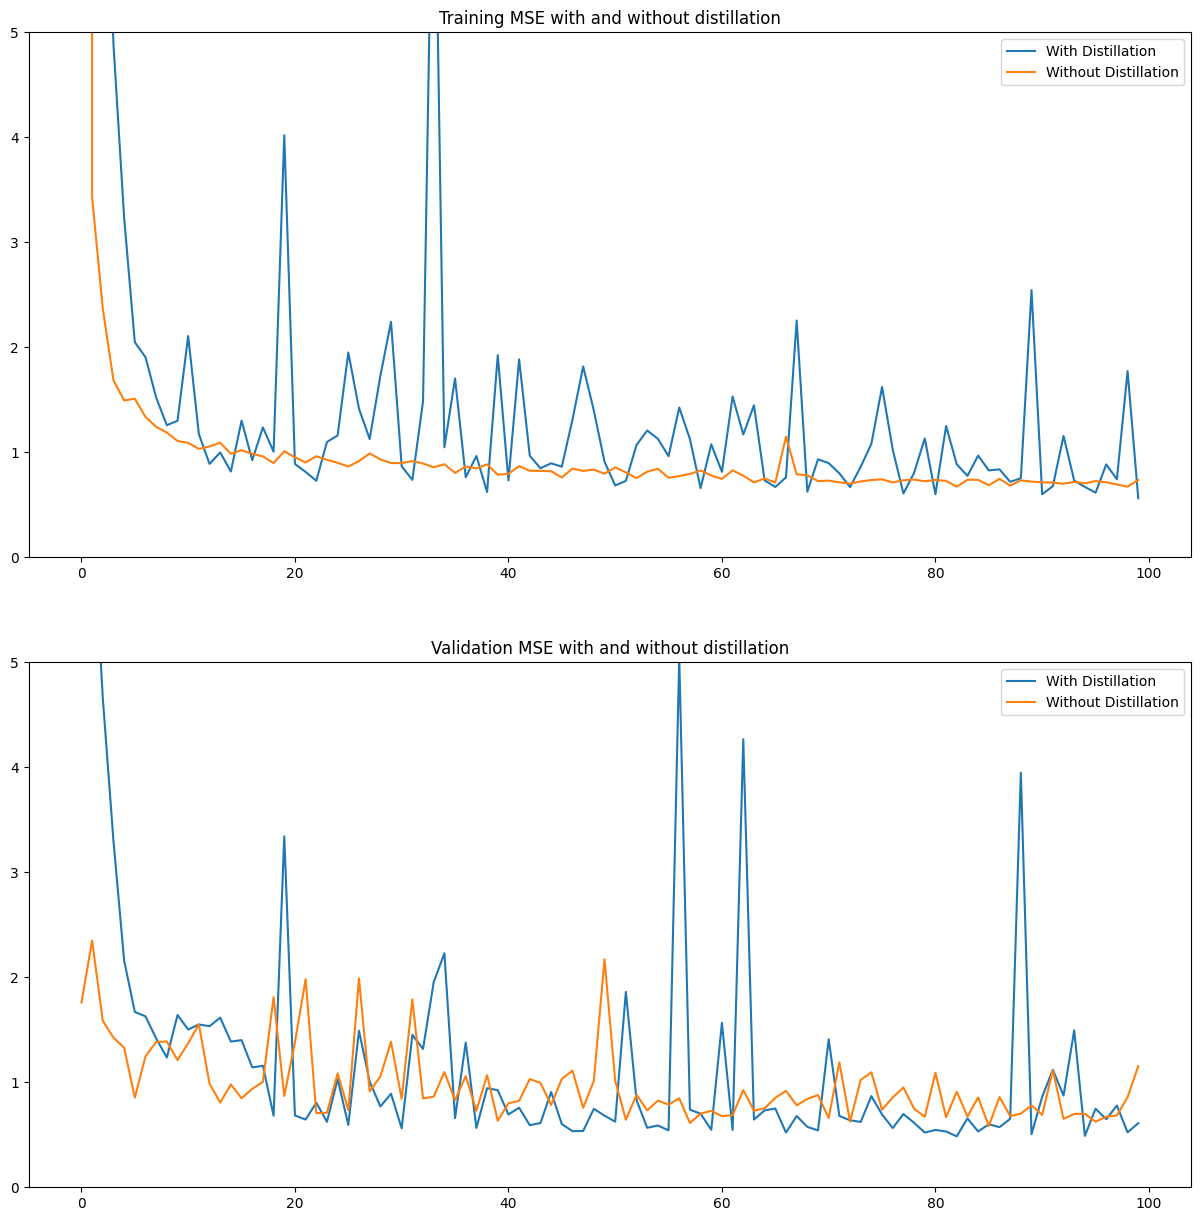

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

x = range(0, number_of_epochs)

# Compute the average on all folds for every epochs for training data
train_mse_with_distillation = np.mean([d['mse'] for d in train_val_results_with_distillation], 0)
train_mse_without_distillation = np.mean([d['mse'] for d in train_val_results_without_distillation], 0)

# Get the MSE for the training dataset
train_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_with_distillation]]
train_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_without_distillation]]

train_with_distillation_mse_std = np.std(train_with_distillation_mse_last_epochs)
train_without_distillation_mse_std = np.std(train_without_distillation_mse_last_epochs)


# Compute the average on all folds for every epochs for validation data
val_mse_with_distillation = np.mean([d['val_mse'] for d in train_val_results_with_distillation], 0)
val_mse_without_distillation = np.mean([d['val_mse'] for d in train_val_results_without_distillation], 0)

# Get the MSE for valiation dataset
val_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_with_distillation]]
val_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_mse'] for d in train_val_results_without_distillation]]

val_with_distillation_mse_stds = np.std(val_with_distillation_mse_last_epochs)
val_without_distillation_mse_stds = np.std(val_without_distillation_mse_last_epochs)


# Traning results
axs[0].plot(x, train_mse_with_distillation) 
axs[0].plot(x, train_mse_without_distillation) 
axs[0].set_ylim(0, 5)
axs[0].title.set_text('Training MSE with and without distillation') 
axs[0].legend(['With Distillation', 'Without Distillation'])  

# Val results
axs[1].plot(x, val_mse_with_distillation) 
axs[1].plot(x, val_mse_without_distillation) 
axs[1].set_ylim(0, 5)
axs[1].title.set_text('Validation MSE with and without distillation') 
axs[1].legend(['With Distillation', 'Without Distillation'])

print(f"Validation mse with distillation {np.round(np.mean(val_with_distillation_mse_last_epochs), 4)} +- {np.round(val_with_distillation_mse_stds, 4)}")
#print(f"Test mse with disstillation {test_results_with_distillation}")

print(f"Validation mse without disstillation {np.round(np.mean(val_without_distillation_mse_last_epochs), 4)} +- {np.round(val_without_distillation_mse_stds, 4)}")
#print(f"Test mse without disstillation {test_results_without_distillation}")

Validation mse with distillation 0.6033 +- 0.1698
Validation mse without disstillation 0.6696 +- 0.3479


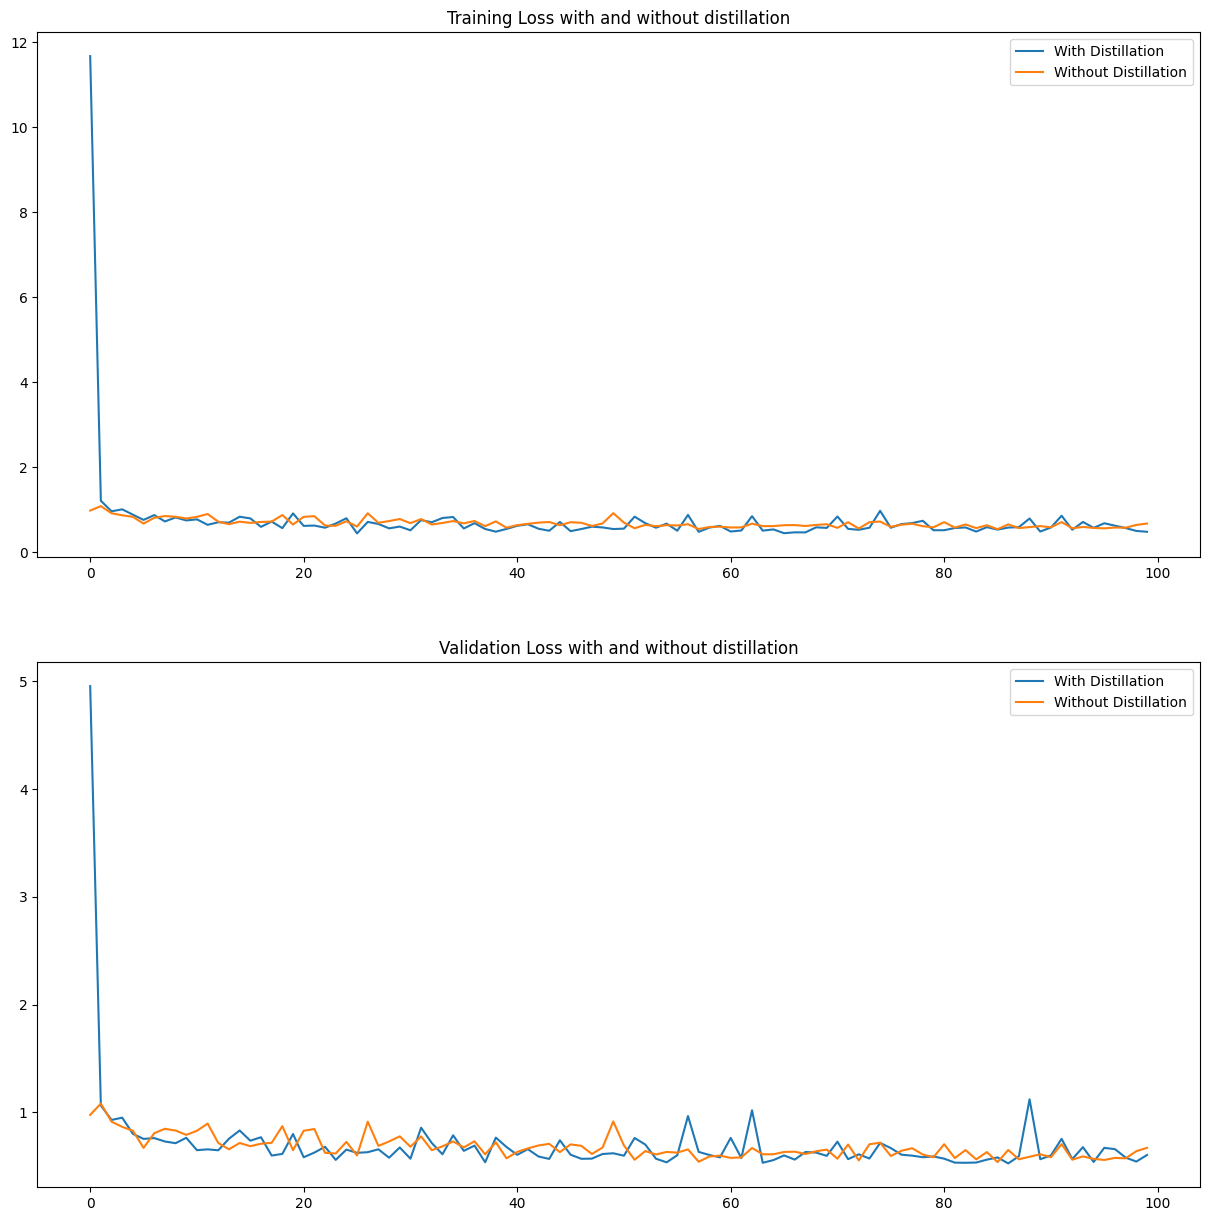

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

x = range(0, number_of_epochs)

# Compute the average on all folds for every epochs for training data
train_mse_with_distillation = np.mean([d['student_loss'] for d in train_val_results_with_distillation], 0)
train_mse_without_distillation = np.mean([d['val_loss'] for d in train_val_results_without_distillation], 0)

# Get the MSE for the training dataset
train_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['student_loss'] for d in train_val_results_with_distillation]]
train_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['loss'] for d in train_val_results_without_distillation]]

train_with_distillation_mse_std = np.std(train_with_distillation_mse_last_epochs)
train_without_distillation_mse_std = np.std(train_without_distillation_mse_last_epochs)


# Compute the average on all folds for every epochs for validation data
val_mse_with_distillation = np.mean([d['val_student_loss'] for d in train_val_results_with_distillation], 0)
val_mse_without_distillation = np.mean([d['val_loss'] for d in train_val_results_without_distillation], 0)

# Get the MSE for valiation dataset
val_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_student_loss'] for d in train_val_results_with_distillation]]
val_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_loss'] for d in train_val_results_without_distillation]]

val_with_distillation_mse_stds = np.std(val_with_distillation_mse_last_epochs)
val_without_distillation_mse_stds = np.std(val_without_distillation_mse_last_epochs)


# Traning results
axs[0].plot(x, train_mse_with_distillation) 
axs[0].plot(x, train_mse_without_distillation) 
#axs[0].set_ylim(0, 5)
axs[0].title.set_text('Training Loss with and without distillation') 
axs[0].legend(['With Distillation', 'Without Distillation'])  

# Val results
axs[1].plot(x, val_mse_with_distillation) 
axs[1].plot(x, val_mse_without_distillation) 
#axs[1].set_ylim(0, 5)
axs[1].title.set_text('Validation Loss with and without distillation') 
axs[1].legend(['With Distillation', 'Without Distillation'])

print(f"Validation mse with distillation {np.round(np.mean(val_with_distillation_mse_last_epochs), 4)} +- {np.round(val_with_distillation_mse_stds, 4)}")

print(f"Validation mse without disstillation {np.round(np.mean(val_without_distillation_mse_last_epochs), 4)} +- {np.round(val_without_distillation_mse_stds, 4)}")

In [11]:
# Train again on the entire traning set and then test
studnet_model = buildStudentModel()
studnet_model_without_distillation = keras.models.clone_model(studnet_model)

distiller = Distiller.Distiller(student=studnet_model, teacher=teacher_model)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['mse', 'mae', 'mape'],
    student_loss_fn=tf.keras.losses.MeanAbsoluteError(),
    distillation_loss_fn=distiller.mse_distillation_loss_fucntion,
    alpha=0.1,
    temperature=10        
)
# Retrain both models
distiller.fit(x_train, y_train, epochs=number_of_epochs)

studnet_model_without_distillation.compile(
    optimizer=keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=['mse', 'mae', 'mape'],
)
studnet_model_without_distillation.fit(x_train, y_train, epochs=number_of_epochs)
    
# Evaluate the models onb the test data when the training is complete    
# Evaluate student on test dataset
test_results_with_distillation = distiller.evaluate(x_test, y_test, return_dict=True)
test_results_without_distillation = studnet_model_without_distillation.evaluate(x_test, y_test, return_dict=True)

Epoch 1/100
492/492 [==============================] - 1s 2ms/step - mse: 7165.1597 - mae: 23.9001 - mape: 1616.2279 - student_loss: 23.8258 - distillation_loss: 7139.4667
Epoch 2/100
492/492 [==============================] - 1s 2ms/step - mse: 7.9885 - mae: 1.9449 - mape: 141.7795 - student_loss: 1.9441 - distillation_loss: 7.7015
Epoch 3/100
492/492 [==============================] - 1s 2ms/step - mse: 4.1234 - mae: 1.4146 - mape: 101.3458 - student_loss: 1.4151 - distillation_loss: 3.7875
Epoch 4/100
492/492 [==============================] - 1s 2ms/step - mse: 3.9608 - mae: 1.2060 - mape: 83.6487 - student_loss: 1.2056 - distillation_loss: 3.6352
Epoch 5/100
492/492 [==============================] - 1s 2ms/step - mse: 2.9296 - mae: 1.0799 - mape: 72.5973 - student_loss: 1.0802 - distillation_loss: 2.5369
Epoch 6/100
492/492 [==============================] - 1s 2ms/step - mse: 2.5223 - mae: 1.0088 - mape: 67.5586 - student_loss: 1.0082 - distillation_loss: 2.0944
Epoch 7/100
492/

492/492 [==============================] - 1s 2ms/step - mse: 1.0804 - mae: 0.7194 - mape: 46.7523 - student_loss: 0.7217 - distillation_loss: 0.6643
Epoch 52/100
492/492 [==============================] - 1s 2ms/step - mse: 0.9712 - mae: 0.7163 - mape: 46.0794 - student_loss: 0.7169 - distillation_loss: 0.5607
Epoch 53/100
492/492 [==============================] - 1s 2ms/step - mse: 3.0430 - mae: 0.9525 - mape: 61.9722 - student_loss: 0.9515 - distillation_loss: 2.6073
Epoch 54/100
492/492 [==============================] - 1s 2ms/step - mse: 2.5381 - mae: 0.8712 - mape: 56.4605 - student_loss: 0.8745 - distillation_loss: 2.1375
Epoch 55/100
492/492 [==============================] - 1s 2ms/step - mse: 0.7134 - mae: 0.6207 - mape: 40.1528 - student_loss: 0.6201 - distillation_loss: 0.3007
Epoch 56/100
492/492 [==============================] - 1s 2ms/step - mse: 0.8663 - mae: 0.6359 - mape: 41.0153 - student_loss: 0.6377 - distillation_loss: 0.4568
Epoch 57/100
492/492 [=============

492/492 [==============================] - 1s 2ms/step - loss: 30.5073 - mse: 8055.1187 - mae: 30.5073 - mape: 1992.6334
Epoch 2/100
492/492 [==============================] - 1s 1ms/step - loss: 1.2374 - mse: 2.4449 - mae: 1.2374 - mape: 55.5370
Epoch 3/100
492/492 [==============================] - 1s 2ms/step - loss: 0.9625 - mse: 1.6550 - mae: 0.9625 - mape: 44.6750
Epoch 4/100
492/492 [==============================] - 1s 2ms/step - loss: 0.8337 - mse: 1.2573 - mae: 0.8337 - mape: 44.0509
Epoch 5/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7842 - mse: 1.0790 - mae: 0.7842 - mape: 46.4948
Epoch 6/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7722 - mse: 1.0168 - mae: 0.7722 - mape: 48.6369
Epoch 7/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7703 - mse: 0.9961 - mae: 0.7703 - mape: 49.7529
Epoch 8/100
492/492 [==============================] - 1s 1ms/step - loss: 0.7699 - mse: 0.9880 - mae: 0.7699 - mape: 50.29

492/492 [==============================] - 1s 2ms/step - loss: 0.5569 - mse: 0.6477 - mae: 0.5569 - mape: 33.1008
Epoch 66/100
492/492 [==============================] - 1s 2ms/step - loss: 0.5571 - mse: 0.6668 - mae: 0.5571 - mape: 33.2570
Epoch 67/100
492/492 [==============================] - 1s 2ms/step - loss: 0.5505 - mse: 0.6400 - mae: 0.5505 - mape: 32.6638
Epoch 68/100
492/492 [==============================] - 1s 1ms/step - loss: 0.5517 - mse: 0.6734 - mae: 0.5517 - mape: 32.8338
Epoch 69/100
492/492 [==============================] - 1s 1ms/step - loss: 0.5498 - mse: 0.7063 - mae: 0.5498 - mape: 32.7392
Epoch 70/100
492/492 [==============================] - 1s 1ms/step - loss: 0.5613 - mse: 0.7136 - mae: 0.5613 - mape: 33.8262
Epoch 71/100
492/492 [==============================] - 1s 1ms/step - loss: 0.5509 - mse: 0.6847 - mae: 0.5509 - mape: 32.8685
Epoch 72/100
492/492 [==============================] - 1s 2ms/step - loss: 0.5515 - mse: 0.7240 - mae: 0.5515 - mape: 32.87

In [12]:
print(f"Test mse with disstillation {test_results_with_distillation}")
print(f"Test mse without disstillation {test_results_without_distillation}")

Test mse with disstillation {'mse': 0.6360344290733337, 'mae': 0.5937817692756653, 'mape': 36.407875061035156, 'student_loss': 0.645311713218689}
Test mse without disstillation {'loss': 0.5821447968482971, 'mse': 0.698464035987854, 'mae': 0.5821447968482971, 'mape': 29.615190505981445}


In [22]:
# # Save the model to load in future
# %mkdir Exp1Models
#%mkdir Exp1Models/Exp2

# studnet_model.save('Exp1Models/Exp2/studnet_model')
# studnet_model_without_distillation.save('Exp1Models/Exp2/studnet_model_without_distillation')

The syntax of the command is incorrect.


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model_without_distillation\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model_without_distillation\assets
